### Battery life model library
Example notebook demonstrating how to use the battery life models in Python.

First examples use the Kokam NMC111|Gr 75Ah battery life model. The battery modeled here is a high-power cell with long cycle life. Because nominal cell resistance is low, the relative change of resistance at end-of-life is quite high compared to other cell designs (~300% increase in cell resistance at 80% capacity if not more). Fade rates can be changed in the code to accomodate other cell models. Documentation is provided in the life model class. See https://ieeexplore.ieee.org/abstract/document/7963578 for the aging test details and results used to parameterize this model.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

To run, the life model needs timeseries data: the time in seconds since beginning-of-life of the battery, the state-of-charge of the battery (0 to 1), and the ambient temperature (or battery temperature, if you have a thermal model).

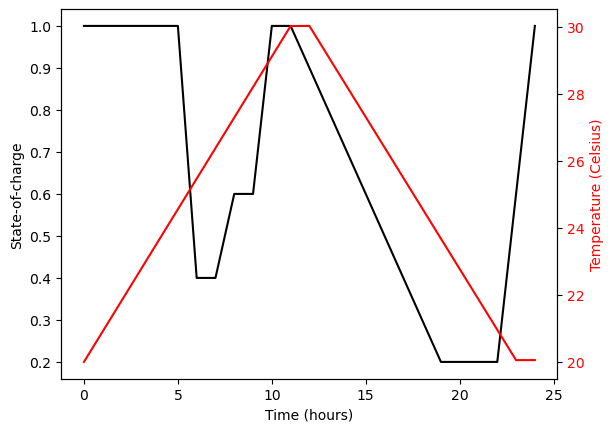

In [2]:
from blast.utils.demo import generate_sample_data

simulation_inputs = generate_sample_data()

fig, ax1 = plt.subplots()
ax1.plot(simulation_inputs['Time_s'][:25] / 3600, simulation_inputs['SOC'][:25], '-k')
ax1.set_xlabel('Time (hours)')
ax1.set_ylabel('State-of-charge')

ax2 = ax1.twinx()
ax2.plot(simulation_inputs['Time_s'][:25] / 3600, simulation_inputs['Temperature_C'][:25], '-r')
ax2.tick_params(axis='y', labelcolor='r')
ax2.set_ylabel('Temperature (Celsius)', color='r')
plt.show()

Climate or SOC inputs can have any amount of variation: hourly, daily, or seasonal variation.

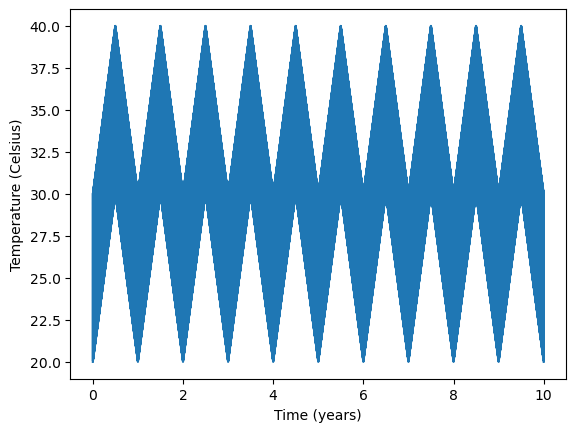

In [3]:
plt.plot(simulation_inputs['Time_s'] / (3600*24*365), simulation_inputs['Temperature_C'])
plt.xlabel('Time (years)')
plt.ylabel('Temperature (Celsius)')
plt.show()

Instantiate the battery model.

In [4]:
from blast.models.nmc111_gr_Kokam75Ah_2017 import Nmc111_Gr_Kokam75Ah_Battery
cell = Nmc111_Gr_Kokam75Ah_Battery()

All battery models have five properties. The first is `cap`, which is the nominal discharge capacity of the cell in Amp hours.

In [5]:
cell.cap

75

The next four track battery lifetime values, and store the history of the battery as lifetime is simulated  at each timestep/iteration:
- `states`: internal states of the battery model
    - Ex., time-dependent capacity loss
- `outputs`: battery properties calculated from states
    - Ex., relative discharge capacity
- `stressors`: values of stressors used by the model
    - Ex., temperature, depth-of-discharge, charge-throughput
    - Note that degradation rates are calculate from stressor timeseries, and then normalized for the timestep; for example, an Arrhenius expression would be evaluated from the temperature timeseries for the entire timestep, and then normalized by taking the time-based average - this gives a different value than if the Arrhenius expression was evaluated on the averager temperature. Other normalizations can include using the minimum or maximum value over the timestep, or using the root-mean-square.
- `rates`: values of degradation rates
    - Ex., time-dependent degradation rate due to temperature and state-of-charge

Battery models may have other properties, such as the open-circuit voltage as a function of state-of-charge, nominal DC resistance values, or first-life/second-life capacity definitions.

This specific battery model is relatively complex, and has many states and outputs that describe the degradation state of the battery. Properties `states`, `outputs`, `stressors`, and `rates` are all stored in dicts:

In [6]:
cell.outputs

{'q': array([1]),
 'q_LLI': array([1]),
 'q_LLI_t': array([1]),
 'q_LLI_EFC': array([1]),
 'q_LAM': array([1.01]),
 'r': array([1]),
 'r_LLI': array([1]),
 'r_LLI_t': array([1]),
 'r_LLI_EFC': array([1]),
 'r_LAM': array([1])}

Output descriptions are in the class definition, replicated here:
- q: relative capacity
- q_LLI: relative lithium inventory
- q_LLI_t: relative lithium inventory, time dependent loss
- q_LLI_EFC: relative lithium inventory, charge-throughput dependent loss
- q_LAM: relative active material, charge-throughput dependent loss
- r: relative resistance
- r_LLI: relative SEI resistance
- r_LLI_t: relative SEI resistance, time dependent growth
- r_LLI_EFC: relative SEI resistance, charge-throughput dependent growth
- r_LAM: relative electrode resistance, q_LAM dependent growth

Accesing one output/state/rate/stressor is simple:

In [7]:
cell.outputs['q']

array([1])

The battery model is run in timesteps relevant to battery degradation: either once a single equivalent full cycle has been completed, or after 1 day. Cycles are detected using the rainflow algorithm, which finds turning points in the SOC profile that are then processed to determine useful simulation timesteps from the SOC profile. This is all done by the `simulate_battery_life` function. The input timeseries vectors needs to be given as a dictionary.

Each battery model tracks the history of it's inputs (`stressors`), calculated degradation rates (`rates`), internal states (`states`), and outputs (`outputs`) each time `update_battery_state` is called. Debugging models is easier because the values of all inputs, internal calculations, and outputs are tracked.

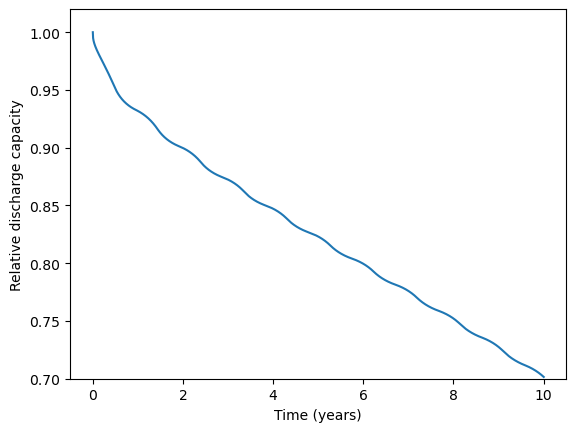

In [8]:
cell.simulate_battery_life(simulation_inputs)

plt.plot(cell.stressors['t_days']/365, cell.outputs['q'])
plt.xlabel('Time (years)')
plt.ylabel('Relative discharge capacity')
plt.ylim((0.7, 1.02))
plt.show()

The cell resistance and capacity trajectories are wiggily because the temperature of the battery is varying throughout each year, varying the degradation rate.

The model keeps track of how much charge-throughput has occured throughout life, as well, based on the input state-of-charge timeseries. Conversion from charge-throughput, in Amp-hours, to changes of cell state-of-charge, which is dependent on battery performance (health, temperature and SOC dependent resistances), is appoximated using an optional input, `is_conserve_energy_throughput`. If true, the SOC swings in the input are magnified as the battery ages to simulate what happens as the battery degrades but energy throughput is constant. If false, the energy throughput for each cycle decreases, as you get less energy from the battery per cycle as the battery degrades. The default value is true, as most people want a battery to give be able to discharge a certain amount of energy throughout it's life.

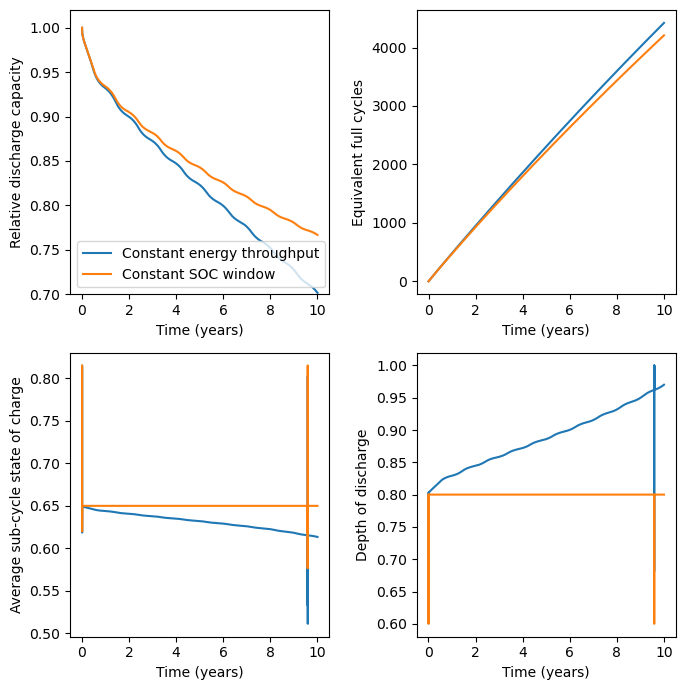

In [22]:
cell_constant_energy = Nmc111_Gr_Kokam75Ah_Battery()
cell_constant_energy.simulate_battery_life(simulation_inputs, is_conserve_energy_throughput=True)

cell_constant_SOC = Nmc111_Gr_Kokam75Ah_Battery()
cell_constant_SOC.simulate_battery_life(simulation_inputs, is_conserve_energy_throughput=False)

fig, ax = plt.subplots(2, 2, figsize=(7,7))
ax = ax.ravel()

ax[0].plot(cell_constant_energy.stressors['t_days']/365, cell_constant_energy.outputs['q'], label='Constant energy throughput')
ax[0].plot(cell_constant_SOC.stressors['t_days']/365, cell_constant_SOC.outputs['q'], label='Constant SOC window')
ax[0].set_xlabel('Time (years)')
ax[0].set_ylabel('Relative discharge capacity')
ax[0].set_ylim((0.7, 1.02))
ax[0].legend(loc='lower left')

ax[1].plot(cell_constant_energy.stressors['t_days']/365, cell_constant_energy.stressors['efc'])
ax[1].plot(cell_constant_SOC.stressors['t_days']/365, cell_constant_SOC.stressors['efc'])
ax[1].set_xlabel('Time (years)')
ax[1].set_ylabel('Equivalent full cycles')

ax[2].plot(cell_constant_energy.stressors['t_days']/365, cell_constant_energy.stressors['soc'])
ax[2].plot(cell_constant_SOC.stressors['t_days']/365, cell_constant_SOC.stressors['soc'])
ax[2].set_xlabel('Time (years)')
ax[2].set_ylabel('Average sub-cycle state of charge')

ax[3].plot(cell_constant_energy.stressors['t_days']/365, cell_constant_energy.stressors['dod'])
ax[3].plot(cell_constant_SOC.stressors['t_days']/365, cell_constant_SOC.stressors['dod'])
ax[3].set_xlabel('Time (years)')
ax[3].set_ylabel('Depth of discharge')

plt.tight_layout()

We can plot the separate contributions to capacity or resistance fade, as well. Some models have competitive degradation states, for instance, in this model 'Loss of Lithium Inventory' limited capacity (q_LLI) and 'Loss of Active Material' limited capacity (q_LAM) are competitive, and the minimum value will limit total capacity. Most models have separate time and cycle- or charge-throughput-dependent terms, which can be useful to separately understand degradation due to time and due to using the battery.

(0.7, 1.02)

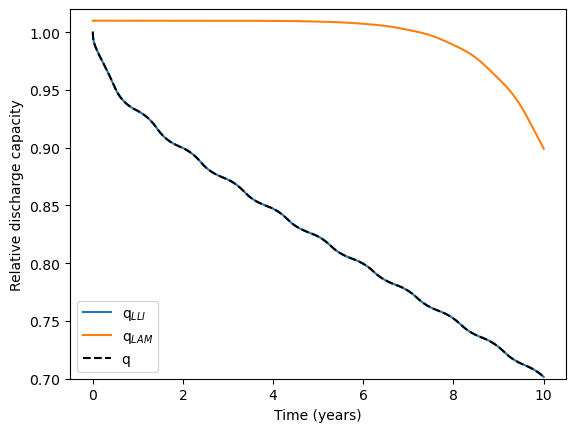

In [23]:
plt.plot(cell.stressors['t_days']/365, cell.outputs['q_LLI'])
plt.plot(cell.stressors['t_days']/365, cell.outputs['q_LAM'])
plt.plot(cell.stressors['t_days']/365, cell.outputs['q'], '--k')
plt.xlabel('Time (years)')
plt.ylabel('Relative discharge capacity')
plt.legend([r'q$_{LLI}$', r'q$_{LAM}$', 'q'])
plt.ylim((0.7, 1.02))

From the result, the cell will experience sudden failure very shortly; considering this is near 70% remaining capacity, this is physically reasonable.
This model also has resistance growth simulated; likely, resistance growth would limit this cell's lifetime before capacity fade would, depending on the application.

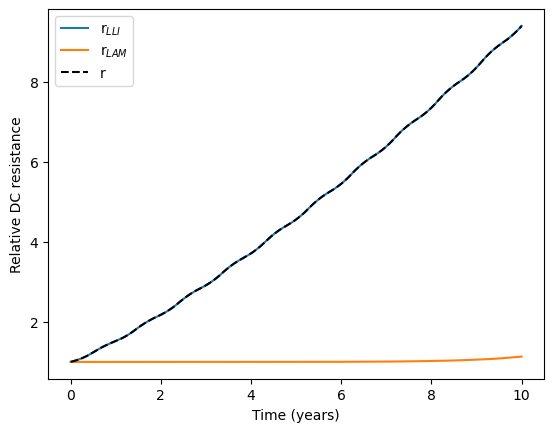

In [24]:
plt.plot(cell.stressors['t_days']/365, cell.outputs['r_LLI'])
plt.plot(cell.stressors['t_days']/365, cell.outputs['r_LAM'])
plt.plot(cell.stressors['t_days']/365, cell.outputs['r'], '--k')
plt.xlabel('Time (years)')
plt.ylabel('Relative DC resistance')
plt.legend([r'r$_{LLI}$', r'r$_{LAM}$', 'r'])
plt.show()

The `simulate_battery_degradation` function has inputs to easily control the duration of the total simulation, or to simulate to some capacity treshold. When extending the simulation, we simply assume the input keeps repeating.

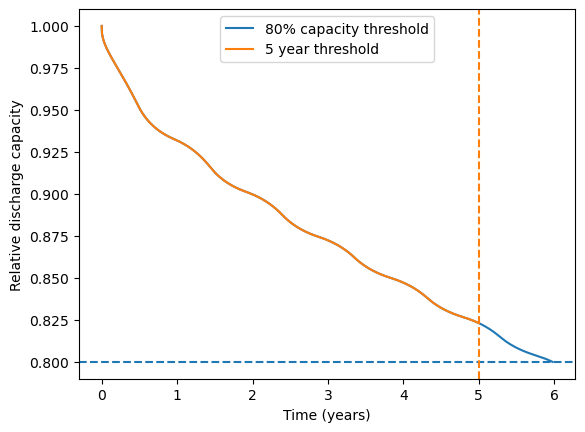

In [ ]:
cell_3years = Nmc111_Gr_Kokam75Ah_Battery()
cell_80percent = Nmc111_Gr_Kokam75Ah_Battery()

cell_3years.simulate_battery_life(simulation_inputs, simulation_years=3)
cell_80percent.simulate_battery_life(simulation_inputs, capacity_threshold=0.8)

plt.plot(cell_80percent.stressors['t_days']/365, cell_80percent.outputs['q'], label='80% capacity threshold')
plt.plot(cell_3years.stressors['t_days']/365, cell_3years.outputs['q'], label='3 year threshold')
plt.axhline(0.8, color='tab:blue', linestyle='--')
plt.axvline(5, color='tab:orange', linestyle='--')
plt.xlabel('Time (years)')
plt.ylabel('Relative discharge capacity')
plt.legend()

The same set of inputs can be used with any battery degradation model.

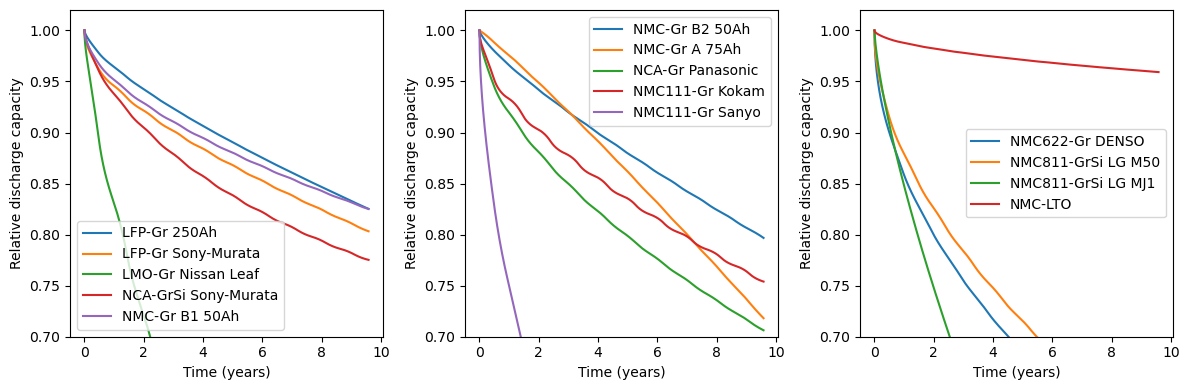

In [12]:
from blast import models
import importlib

def simulate_all_models(*args, **kwargs):
    battery_models = models.available_models()
    cells = []
    for model in battery_models:
        This_Battery_Model = getattr(importlib.import_module("blast.models"), model)
        cell = This_Battery_Model()
        cell.simulate_battery_life(*args, **kwargs)
        cells.append(cell)
    
    return cells

cells = simulate_all_models(simulation_inputs)

fig, ax = plt.subplots(1, 3, figsize=(12,4))
for i, cell in enumerate(cells):
    if i < 5:
        ax[0].plot(cell.stressors['t_days']/365, cell.outputs['q'], label=cell._label)
    elif i < 10:
        ax[1].plot(cell.stressors['t_days']/365, cell.outputs['q'], label=cell._label)
    else:
        ax[2].plot(cell.stressors['t_days']/365, cell.outputs['q'], label=cell._label)

for axis in ax:
    axis.set_xlabel('Time (years)')
    axis.set_ylabel('Relative discharge capacity')
    axis.set_ylim((0.7, 1.02))
    axis.legend()
plt.tight_layout()